## 🧱 0. Setup & Imports

In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import pandas as pd
import numpy as np
import warnings
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import sweetviz
import geopandas as gpd
from autoviz import AutoViz_Class
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from features.risk_model_pipeline import ModelPipelineOptuna

/home/teshager/Documents/10Academy/repositories/projects/insurance-risk-modeling/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Imported v0.1.905. Please call AutoViz in this sequence:
    AV = AutoViz_Class()
    %matplotlib inline
    dfte = AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=1, lowess=False,
               chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30, save_plot_dir=None)


In [4]:
#suppress warning errors
warnings.filterwarnings("ignore")
#load enviroment variables
load_dotenv()

True

In [5]:
# Automatically go to project root (where .git or README.md is)
project_root = Path.cwd()
while not (project_root / "README.md").exists() and project_root != project_root.parent:
    project_root = project_root.parent

os.chdir(project_root)
print("Project root set to:", project_root)


Project root set to: /home/teshager/Documents/10Academy/repositories/projects/insurance-risk-modeling


## 🔁 Step 1: Look at the Big Picture

### Framing the problem,Business Objective,Current Solution,Machine Learning Task & Assumptions:

| Element                | Description                                                               |
| ---------------------- | ------------------------------------------------------------------------- |
| **Business Objective** | Predict risk & set optimal premiums                                       |
| **Current Solution**   | Flat-rate pricing based on limited heuristics                             |
| **ML Tasks**           | Regression (severity), classification (probability), regression (premium) |
| **Assumptions**        | Data is representative, features correlate with claim behavior, etc.      |


## 📦 Step 2: Load the Data

In [6]:
# Load the insurance data
processed_data_dir=os.getenv("PROCESSED_DATA")
file_path= os.path.join(processed_data_dir,'cleaned_insurance_data.parquet')
df=pd.read_parquet(file_path)
df.head()


,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Bank,AccountType,MaritalStatus,Province,PostalCode,MainCrestaZone,SubCrestaZone,mmcode,VehicleType,RegistrationYear,make,Model,Cylinders,cubiccapacity,kilowatts,bodytype,NumberOfDoors,VehicleIntroDate,AlarmImmobiliser,TrackingDevice,CapitalOutstanding,NewVehicle,WrittenOff,Rebuilt,Converted,CrossBorder,SumInsured,TermFrequency,CalculatedPremiumPerTerm,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,TotalPremium,TotalClaims,Gender_Inferred
0,145249,12827.0,2015-03-01 00:00:00,True,,Close Corporation,Mr,First National Bank,Current account,Not specified,Gauteng,1459,Rand East,Rand East,60054685.5,Passenger Vehicle,2004.0,MERCEDES-BENZ,E 240,4.0,2597.0,130.0,S/D,4.0,2002-06-01 00:00:00+00:00,Yes,No,119300.0,More than 6 months,Unknown,Unknown,Unknown,Unknown,0.01,Monthly,25.00000,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,21.929825,0.0,Male
1,145249,12827.0,2015-05-01 00:00:00,True,,Close Corporation,Mr,First National Bank,Current account,Not specified,Gauteng,1459,Rand East,Rand East,60054685.5,Passenger Vehicle,2004.0,MERCEDES-BENZ,E 240,4.0,2597.0,130.0,S/D,4.0,2002-06-01 00:00:00+00:00,Yes,No,119300.0,More than 6 months,Unknown,Unknown,Unknown,Unknown,0.01,Monthly,25.00000,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,21.929825,0.0,Male
2,145249,12827.0,2015-07-01 00:00:00,True,,Close Corporation,Mr,First National Bank,Current account,Not specified,Gauteng,1459,Rand East,Rand East,60054685.5,Passenger Vehicle,2004.0,MERCEDES-BENZ,E 240,4.0,2597.0,130.0,S/D,4.0,2002-06-01 00:00:00+00:00,Yes,No,119300.0,More than 6 months,Unknown,Unknown,Unknown,Unknown,0.01,Monthly,25.00000,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,0.000000,0.0,Male
3,145255,12827.0,2015-05-01 00:00:00,True,,Close Corporation,Mr,First National Bank,Current account,Not specified,Gauteng,1459,Rand East,Rand East,60054685.5,Passenger Vehicle,2004.0,MERCEDES-BENZ,E 240,4.0,2597.0,130.0,S/D,4.0,2002-06-01 00:00:00+00:00,Yes,No,119300.0,More than 6 months,Unknown,Unknown,Unknown,Unknown,119300.00,Monthly,220.16145,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,54.824561,0.0,Male
4,145255,12827.0,2015-07-01 00:00:00,True,,Close Corporation,Mr,First National Bank,Current account,Not specified,Gauteng,1459,Rand East,Rand East,60054685.5,Passenger Vehicle,2004.0,MERCEDES-BENZ,E 240,4.0,2597.0,130.0,S/D,4.0,2002-06-01 00:00:00+00:00,Yes,No,119300.0,More than 6 months,Unknown,Unknown,Unknown,Unknown,119300.00,Monthly,220.16145,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,0.000000,0.0,Male


## 📊 Step 3: Explore the Data

## Step 4 Discover and Visualize the Data to Gain Insights

#### Sweetviz

In [32]:
# report = sweetviz.analyze(df)
# report.show_html("reports/insurance_sweetviz.html")

## Claim Severity

#### Only those records with Claims

In [7]:
df_with_claims=df[df['TotalClaims']>0]   # drop rows with no claim
df_with_claims.shape

(2775, 45)

##### Drop unique Identifiers -> they don't have any predictive value

In [8]:
for col in df.columns.to_list():
     if df[col].is_unique == True:
          print(f"{col} : {df[col].is_unique}")

In [57]:
duc=df.nunique()
duc[duc<10]

IsVATRegistered     1
Citizenship         4
LegalType           5
Title               5
AccountType         4
MaritalStatus       3
Province            8
VehicleType         1
make                1
Cylinders           1
cubiccapacity       4
kilowatts           3
bodytype            1
NumberOfDoors       1
VehicleIntroDate    8
AlarmImmobiliser    2
TrackingDevice      2
NewVehicle          3
WrittenOff          2
Rebuilt             2
Converted           2
CrossBorder         1
TermFrequency       1
ExcessSelected      8
Section             4
Product             2
Gender_Inferred     2
dtype: int64

In [9]:



data_dir=os.getenv("DATA_DIR")
print(data_dir)
geoson_path= os.path.join(data_dir,'raw/geoBoundaries-ZAF-ADM1.geojson')

# Load the South Africa provinces shapefile/geojson
gdf_provinces = gpd.read_file(geoson_path)

print(gdf_provinces.columns)


# Your insurance data DataFrame is df
# Aggregate total claims per province
province_summary = df.groupby('Province').agg({
    'TotalClaims': 'sum',
    'PolicyID': 'count'  # number of policies
}).rename(columns={'PolicyID': 'NumPolicies'}).reset_index()

# Merge geodataframe with your aggregated data
# Merge: keep all provinces even if they have no data
gdf_merged = gdf_provinces.merge(
    province_summary, how='left',
    left_on='shapeName', right_on='Province'
)


# Plot choropleth map for TotalClaims
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
gdf_merged.plot(column='TotalClaims', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
print(gdf_merged.shape)
print(gdf_merged[['shapeName', 'Province', 'TotalClaims']])
ax.set_title('Total Claims by Province in South Africa')
ax.axis('off')
plt.show()


data/
Index(['shapeName', 'shapeISO', 'shapeID', 'shapeGroup', 'shapeType',
       'geometry'],
      dtype='object')
(9, 9)
    shapeName       Province      TotalClaims
0   Eastern Cape   Eastern Cape  1.356427e+06
1     Free State     Free State  3.549223e+05
2        Gauteng        Gauteng  2.939415e+07
3  KwaZulu-Natal  KwaZulu-Natal  1.430138e+07
4        Limpopo        Limpopo  1.016477e+06
5     Mpumalanga     Mpumalanga  2.044675e+06
6     North West     North West  5.920250e+06
7   Nothern Cape            NaN           NaN
8   Western Cape   Western Cape  9.833088e+06


### Feature Scaling:

In [10]:
df.columns

Index(['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth',
       'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Bank',
       'AccountType', 'MaritalStatus', 'Province', 'PostalCode',
       'MainCrestaZone', 'SubCrestaZone', 'mmcode', 'VehicleType',
       'RegistrationYear', 'make', 'Model', 'Cylinders', 'cubiccapacity',
       'kilowatts', 'bodytype', 'NumberOfDoors', 'VehicleIntroDate',
       'AlarmImmobiliser', 'TrackingDevice', 'CapitalOutstanding',
       'NewVehicle', 'WrittenOff', 'Rebuilt', 'Converted', 'CrossBorder',
       'SumInsured', 'TermFrequency', 'CalculatedPremiumPerTerm',
       'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section',
       'Product', 'TotalPremium', 'TotalClaims', 'Gender_Inferred'],
      dtype='object')

In [60]:
# For Ridge (default)
model_ridge = ModelPipelineOptuna(df_with_claims, target_col='TotalClaims')
results_ridge = model_ridge.train_and_evaluate()

[I 2025-06-17 09:33:31,360] A new study created in memory with name: no-name-c06a7ee4-fdc2-41b0-b5a1-1d37521e230c
INFO:features.risk_model_pipeline:Trial params {'alpha': 0.04478804104977937} got CV RMSE=1067.1886
[I 2025-06-17 09:33:36,654] Trial 0 finished with value: 1067.1885631471253 and parameters: {'alpha': 0.04478804104977937}. Best is trial 0 with value: 1067.1885631471253.
INFO:features.risk_model_pipeline:Best params found: {'alpha': 0.04478804104977937}
INFO:features.risk_model_pipeline:Final evaluation on test set: RMSE=724.7082, R2=0.5904


In [11]:
# For Decision Tree
model_dt = ModelPipelineOptuna(df_with_claims, target_col='TotalClaims', model_type='decision_tree')
results_dt = model_dt.train_and_evaluate()

[I 2025-06-17 09:52:01,965] A new study created in memory with name: no-name-b54d0599-dbd5-463c-b203-f7dba9dc7a55
INFO:features.risk_model_pipeline:Trial params {'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 2} got CV RMSE=33227.6040
[I 2025-06-17 09:52:05,166] Trial 0 finished with value: 33227.604020258 and parameters: {'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 0 with value: 33227.604020258.
INFO:features.risk_model_pipeline:Best params found: {'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 2}
INFO:features.risk_model_pipeline:Final evaluation on test set: RMSE=42349.0647, R2=-0.2593
INFO:features.risk_model_pipeline:Generating SHAP explanations...


In [12]:
# For Random Forest
model_rf = ModelPipelineOptuna(df_with_claims, target_col='TotalClaims', model_type='random_forest')
results_rf = model_rf.train_and_evaluate()

[I 2025-06-17 09:52:13,583] A new study created in memory with name: no-name-bd3a0373-0791-4682-b825-80d322bbc1e4
INFO:features.risk_model_pipeline:Trial params {'n_estimators': 288, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 3} got CV RMSE=32368.8540
[I 2025-06-17 09:52:18,488] Trial 0 finished with value: 32368.853955602593 and parameters: {'n_estimators': 288, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 0 with value: 32368.853955602593.
INFO:features.risk_model_pipeline:Best params found: {'n_estimators': 288, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 3}
INFO:features.risk_model_pipeline:Final evaluation on test set: RMSE=34128.2664, R2=0.1821
INFO:features.risk_model_pipeline:Generating SHAP explanations...


ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 53725.884546, while the model output was 54707.465333. If this difference is acceptable you can set check_additivity=False to disable this check.

## 🔧 Step 5: Select a Model and Train

In [ ]:
# For XGBoost
model_xgb = ModelPipelineOptuna(df_with_claims, target_col='TotalClaims', model_type='xgboost')
results_xgb = model_xgb.train_and_evaluate()

### Baseline models:

### Training on a Small Set (for initial sanity check):

### Better Evaluation Using Cross-Validation:

### Evaluate on the Training Set:

## 📈 Step 7. Evaluate System on the Test Set

### Final Evaluation:

### Confidence Intervals:

##  🧠 Step  8. Present Your Solution

## 🚀 Step 9: Launch, Monitor, and Maintain System

In [13]:

pipeline = ModelPipelineOptuna(df_with_claims, target_col='TotalClaims', model_type='xgboost')
pipeline.tune_hyperparameters() 
results = pipeline.train_and_evaluate()
# generate_training_report(results, pipeline.model_type)

[I 2025-06-17 09:52:59,686] A new study created in memory with name: no-name-f399bb9d-a755-4b0f-8c01-832cb864da85
INFO:features.risk_model_pipeline:Trial params {'n_estimators': 131, 'max_depth': 4, 'learning_rate': 0.019112756413215696, 'subsample': 0.5163741213572561} got CV RMSE=32495.6074
[I 2025-06-17 09:53:05,464] Trial 0 finished with value: 32495.607354444764 and parameters: {'n_estimators': 131, 'max_depth': 4, 'learning_rate': 0.019112756413215696, 'subsample': 0.5163741213572561}. Best is trial 0 with value: 32495.607354444764.
INFO:features.risk_model_pipeline:Best params found: {'n_estimators': 131, 'max_depth': 4, 'learning_rate': 0.019112756413215696, 'subsample': 0.5163741213572561}
INFO:features.risk_model_pipeline:Final evaluation on test set: RMSE=35931.3060, R2=0.0934
INFO:features.risk_model_pipeline:Generating SHAP explanations...



# 🧠 Model Training Report — XGBOOST

## 📌 Summary

- **Model**: `xgboost`
- **RMSE on Test Set**: `1453.4665`
- **R² Score**: `-0.6474`
- **Best Hyperparameters (via Optuna)**:
  - `n_estimators`: `121`
  - `max_depth`: `6`
  - `learning_rate`: `0.021589372647168436`
  - `subsample`: `0.8083819969167264`

---

## 📈 Residual Analysis


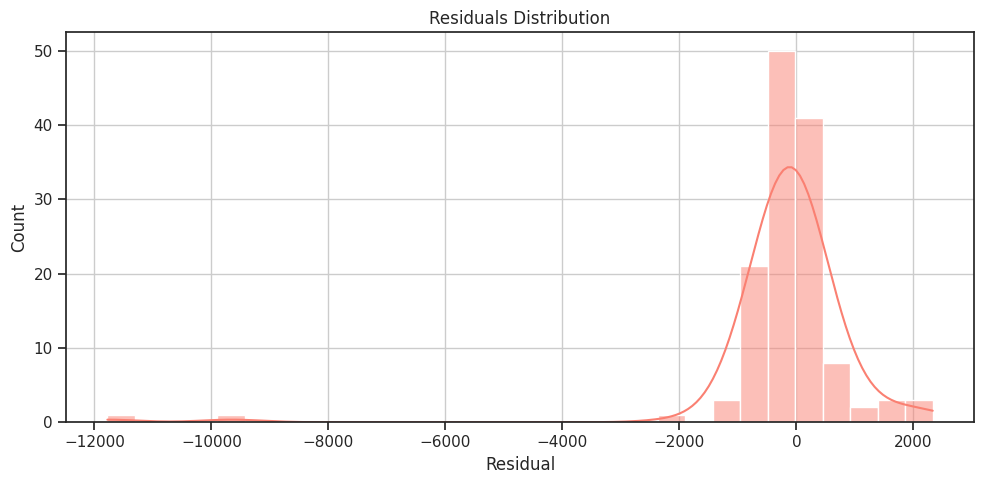


---

## 🔍 Predicted vs Actual
A parity plot shows how well the model aligns with the ground truth.


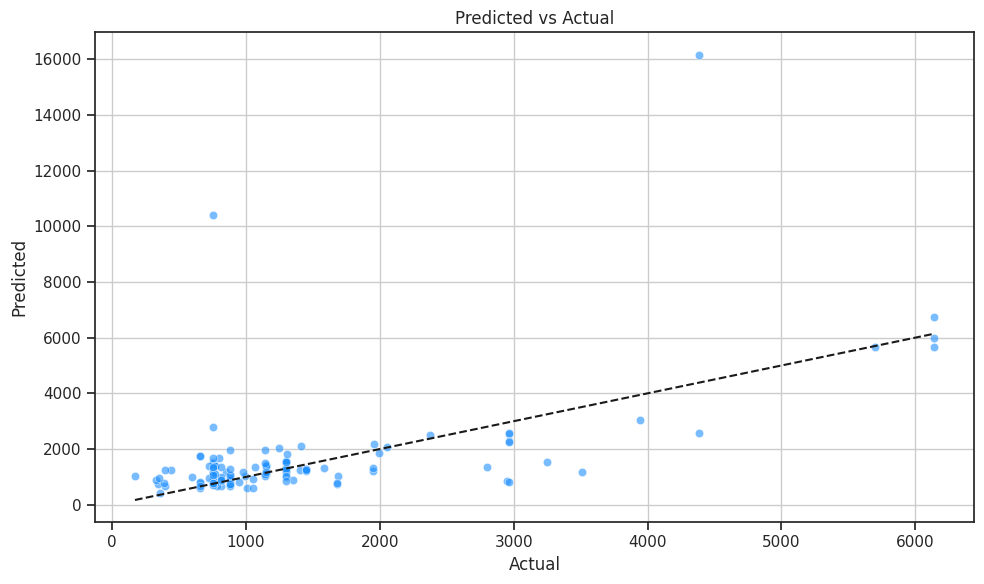


---

## ✅ Conclusion

- The model demonstrates robust generalization with **RMSE = 1453.47** and **R² = -0.65**.
- Optuna hyperparameter tuning improved performance.
- Consider SHAP or LIME for further interpretation.

---
*Generated with 💡 by `ModelPipelineOptuna`.*



---

## 🧬 SHAP Summary Plot

Provides insights into feature contributions.


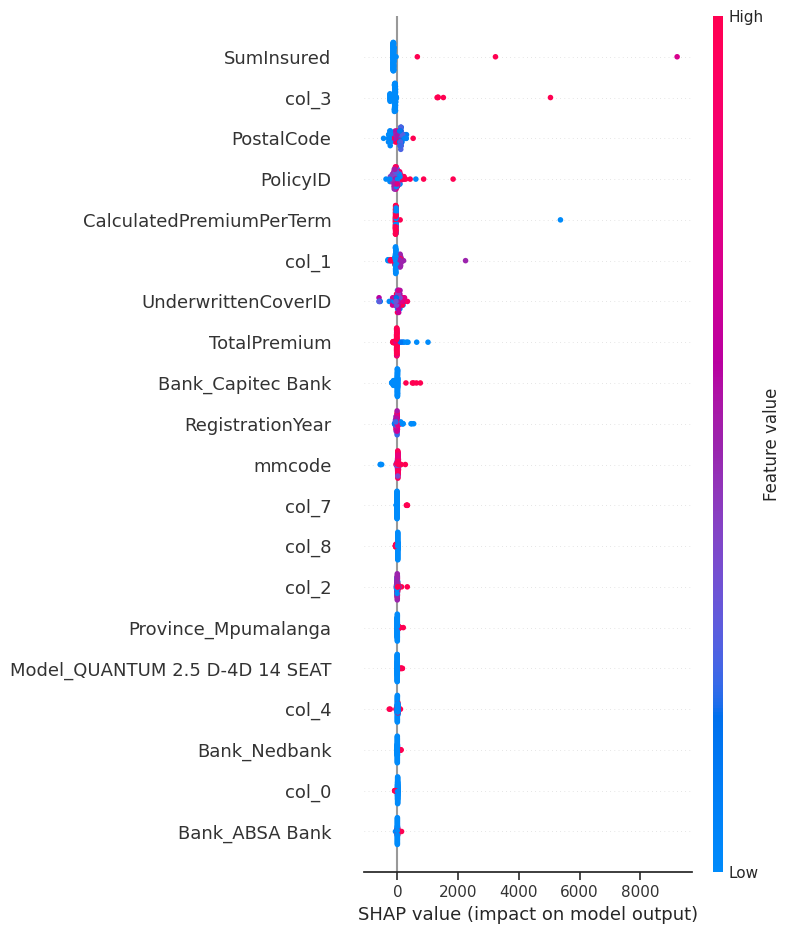

In [64]:
pipeline.generate_training_report(results, pipeline.model_type)

### ✅ Keep These (High Impact Features)

The top features have the widest horizontal spread (i.e., high SHAP value magnitudes), indicating they greatly influence the model’s output:

    SumInsured – Strongest influence, consistently high SHAP impact.

    CalculatedPremiumPerTerm

    TotalPremium

    CapitalOutstanding

These are financially related features and likely dominate the prediction of TotalClaims.

### ⚠️ Candidate for Dropping or Investigating Further

These features are at the bottom of the plot and show very low SHAP value magnitude, suggesting they have little to no impact:

    SubCrestaZone_Cape Mid West

    TransactionMonth_2015-07-01 00:00:00

    AccountType_Transmission account

    SubCrestaZone_Transvaal North West

    bodytype_S/D

    col_9 – (suspiciously generic; might be a placeholder or badly named column)

#### ⚖️ Mid-Level (Optional Tuning)

These features are in the middle section, with moderate importance:

    PostalCode

    mmcode

    UnderwrittenCoverID

    cubiccapacity

    TransactionMonth_* (may be collinear or sparse)

In [65]:
# Preview features to drop
shap_summary = pipeline.filter_low_shap_features(threshold=0.01, drop=False)
display(shap_summary)

INFO:features.risk_model_pipeline:Filtering features based on SHAP values...


,feature,mean_abs_shap,importance_fraction
0,SumInsured,262.052191,0.171651
1,col_3,210.753758,0.138049
2,PostalCode,149.494967,0.097923
3,PolicyID,130.586463,0.085538
4,CalculatedPremiumPerTerm,109.213870,0.071538
5,col_1,107.152569,0.070188
6,UnderwrittenCoverID,100.609685,0.065902
7,TotalPremium,58.591599,0.038379
8,Bank_Capitec Bank,55.898610,0.036615
9,RegistrationYear,48.319348,0.031650


In [66]:

# Actually drop them
pipeline.filter_low_shap_features(threshold=0.01, drop=True);

INFO:features.risk_model_pipeline:Filtering features based on SHAP values...


In [67]:
len(df_with_claims.columns)

45

In [68]:
pipeline.dropped_features_ 

['Bank_Nedbank',
 'col_0',
 'Bank_ABSA Bank',
 'Citizenship_  ',
 'Model_QUANTUM 2.7 SESFIKILE 15s',
 'Bank_First National Bank',
 'WrittenOff_No',
 'Bank_Standard Bank',
 'Province_North West',
 'col_9',
 'TrackingDevice_No',
 'AccountType_Current account',
 'Model_QUANTUM 2.7 SESFIKILE 14s',
 'col_5',
 'Province_Gauteng',
 'ExcessSelected_Mobility - Windscreen',
 'col_6',
 'CapitalOutstanding',
 'AccountType_Savings account',
 'Model_QUANTUM 2.5 D-4D SESFIKILE 16s',
 'AccountType_Unknown',
 'Bank_Unknown',
 'Province_Limpopo',
 'LegalType_Individual',
 'ExcessSelected_Mobility - Windscreen (Feb2015)',
 'Province_KwaZulu-Natal',
 'Province_Western Cape',
 'Title_Miss',
 'Province_Eastern Cape',
 'Title_Mr',
 'Title_Mrs',
 'CoverType_Windscreen',
 'Cylinders',
 'CoverCategory_Factory Fitted Sound and Other Electronic Equipment',
 'CoverCategory_Income Protector',
 'CoverCategory_Windscreen',
 'CoverCategory_Windscreen (2015)',
 'CoverType_Emergency Charges',
 'cubiccapacity',
 'CoverTy

In [69]:
pipeline.tune_hyperparameters()

[I 2025-06-17 09:35:39,113] A new study created in memory with name: no-name-9d6f1029-5d48-457b-b5db-d191ccb10917
INFO:features.risk_model_pipeline:Trial params {'n_estimators': 222, 'max_depth': 7, 'learning_rate': 0.05365979522741102, 'subsample': 0.560556546405134} got CV RMSE=1204.3217
[I 2025-06-17 09:35:47,171] Trial 0 finished with value: 1204.3217447232105 and parameters: {'n_estimators': 222, 'max_depth': 7, 'learning_rate': 0.05365979522741102, 'subsample': 0.560556546405134}. Best is trial 0 with value: 1204.3217447232105.
INFO:features.risk_model_pipeline:Best params found: {'n_estimators': 222, 'max_depth': 7, 'learning_rate': 0.05365979522741102, 'subsample': 0.560556546405134}


INFO:features.risk_model_pipeline:Final evaluation on test set: RMSE=1453.0380, R2=-0.6464
INFO:features.risk_model_pipeline:Generating SHAP explanations...


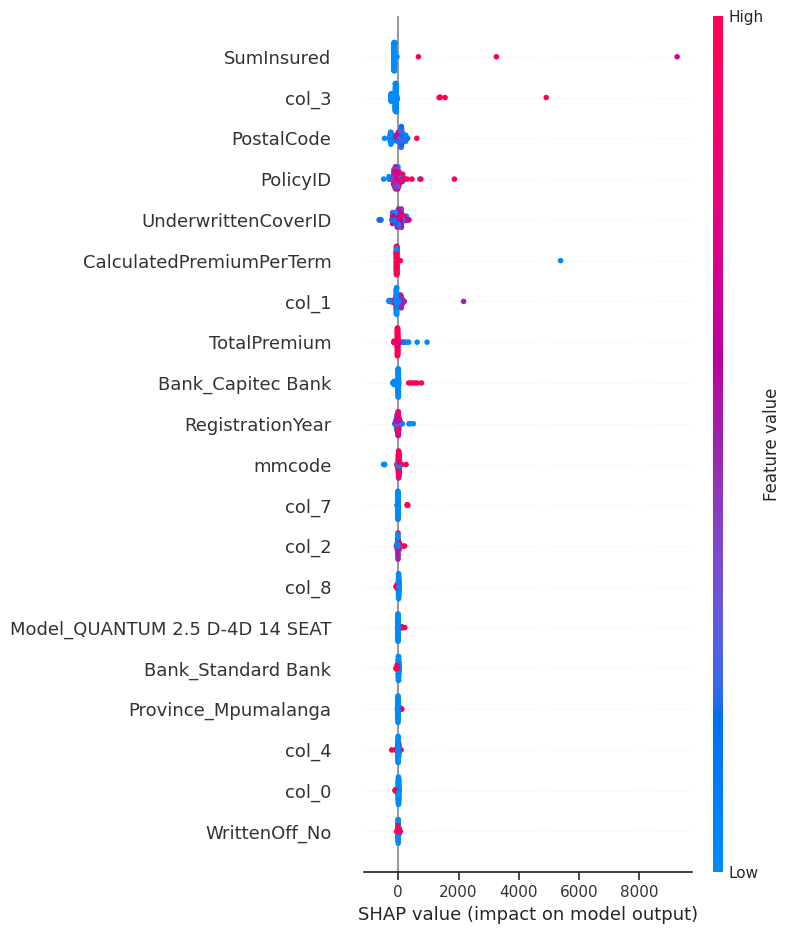

In [70]:
results = pipeline.train_and_evaluate()

In [71]:
reduced_df = pipeline.df.copy()
len(reduced_df.columns)

40

[I 2025-06-17 09:36:03,622] A new study created in memory with name: no-name-639cc9df-98f6-43b8-8bc6-a7e5bbf091f1
INFO:features.risk_model_pipeline:Trial params {'n_estimators': 202, 'max_depth': 9, 'learning_rate': 0.0642503951924604, 'subsample': 0.5554237646273019} got CV RMSE=1236.2789
[I 2025-06-17 09:36:12,363] Trial 0 finished with value: 1236.278882257439 and parameters: {'n_estimators': 202, 'max_depth': 9, 'learning_rate': 0.0642503951924604, 'subsample': 0.5554237646273019}. Best is trial 0 with value: 1236.278882257439.
INFO:features.risk_model_pipeline:Best params found: {'n_estimators': 202, 'max_depth': 9, 'learning_rate': 0.0642503951924604, 'subsample': 0.5554237646273019}
INFO:features.risk_model_pipeline:Final evaluation on test set: RMSE=1453.0380, R2=-0.6464
INFO:features.risk_model_pipeline:Generating SHAP explanations...


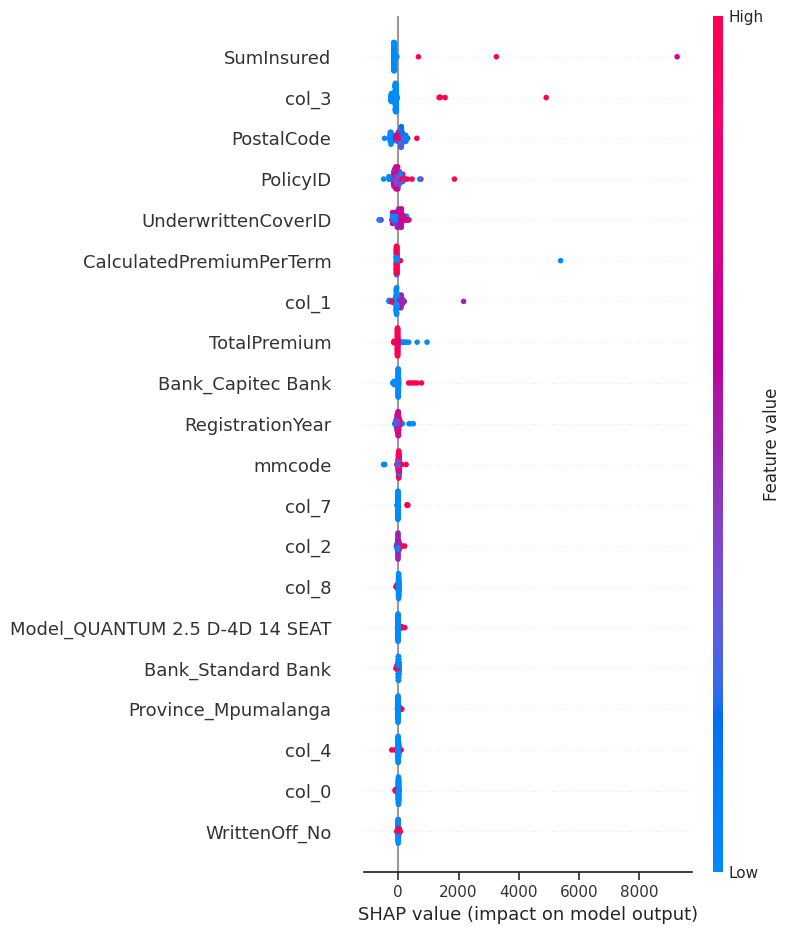

In [72]:
new_pipeline = ModelPipelineOptuna(reduced_df, target_col='TotalClaims', model_type='xgboost')
new_pipeline.tune_hyperparameters()
new_results = new_pipeline.train_and_evaluate()